In [ ]:
# Import gensim package
import gensim
from gensim.summarization import summarize

# Import sumy package
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.kl import KLSummarizer

# import ntlk package
import nltk
nltk.download('punkt')

# import additional libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations
import time


# import pytorch 
import torch
from transformers import LongformerTokenizer, EncoderDecoderModel
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config
device = torch.device('cuda')

In [ ]:
data_dir = ''
data_path = 'filtered_export.csv'

In [ ]:
df = pd.read_csv(data_path)
# df = df.sample(100)
df.head()

,CELEX,Text,labels
0,21980D1231(03),21980D1231(03) Decision No 3/80 of the EEC-Ice...,"['Greece', 'agreement (EU)', 'accession to the..."
1,21986A1115(03),15.11.1986 EN Official Journal of the European...,"['Portugal', 'protocol to an agreement', 'acce..."
2,21987A0720(02),20.7.1987 EN Official Journal of the European ...,"['protocol to an agreement', 'revision of an a..."
3,21987D0411(04),21987D0411(04) Decision No 3/86 of the EEC-Swe...,['originating product']
4,21987D0411(05),21987D0411(05) Decision No 3/86 of the EEC-Swi...,['originating product']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199704 entries, 0 to 199703
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   CELEX   199704 non-null  object
 1   Text    199704 non-null  object
 2   labels  199704 non-null  object
dtypes: object(3)
memory usage: 4.6+ MB


# [What is Text Summarization?](https://www.machinelearningplus.com/nlp/text-summarization-approaches-nlp-example/)

> Text summarization is the technique for generating a concise and precise summary of voluminous texts while focusing on the sections that convey useful information, and without losing the overall meaning.

#  Types of Text Summarization
- **Extractive text summarization** - It is the traditional method developed first. The main objective is to identify the significant sentences of the text and add them to the summary. You need to note that the summary obtained contains exact sentences from the original text.
- **Abstractive text summarization** - It is a more advanced method, many advancements keep coming out frequently(I will cover some of the best here). The approach is to identify the important sections, interpret the context and reproduce in a new way. This ensures that the core information is conveyed through shortest text possible. Note that here, the sentences in summary are generated, not just extracted from original text.

## Text Summarization Extractive Approaches

### What is TextRank algorithm?

> TextRank is an extractive summarization technique. It is based on the concept that words which occur more frequently are significant. Hence , the sentences containing highly frequent words are important. Based on this , the algorithm assigns scores to each sentence in the text . The top-ranked sentences make it to the summary.

### Types of TextRank Algorithms

- **LexRank** -  A sentence which is similar to many other sentences of the text has a high probability of being important. The approach of LexRank is that a particular sentence is recommended by other similar sentences and hence is ranked higher.
- **Luhn** - Luhn Summarization algorithm is based on TF-IDF (Term Frequency-Inverse Document Frequency). It is useful when very low frequent words as well as highly frequent words(stopwords) are both not significant.
- **Latent Semantic Analysis(LSA)** -  a unsupervised learning algorithm that can be used for extractive text summarization. It extracts semantically significant sentences by applying singular value decomposition(SVD) to the matrix of term-document frequency.
- **KL-Sum** - It selects sentences based on similarity of word distribution as the original text. It aims to lower the KL-divergence criteria (learn more). It uses greedy optimization approach and keeps adding sentences till the KL-divergence decreases.


### [1. Text Summarize using gensim](https://radimrehurek.com/gensim_3.8.3/auto_examples/tutorials/run_summarization.html)

In [ ]:
def summarization(x):
    try:
        return summarize(x, word_count = 512)
    except:
        print("Exception!")
        return x

In [ ]:
start = time.time()
df['gensim_summary'] = df['Text'].apply(summarization)
end = time.time()
minutes = int(end - start)//60
print(f'Converting time: {minutes//60} hours and {minutes%60} minutes!')

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
(df['Text'] == df['gensim_summary']).sum()

In [ ]:
df[df['gensim_summary']==""]

In [ ]:
df_filter = df[df['Text'] != df['gensim_summary']]
plt.hist(df_filter['gensim_summary'].apply(lambda x: len(x.split())) / df_filter['Text'].apply(lambda x: len(x.split())),  bins = 100)
plt.title('gensim_summary and Original Text Ratio')
plt.show()

### [2. Text Summarize with Sumy](https://medium.com/@ondenyi.eric/extractive-text-summarization-techniques-with-sumy-3d3b127a0a32)

#### 2.1 LexRank

In [ ]:
def lexranksummarization(x):
    try:
        # Initializing the parser
        my_parser = PlaintextParser.from_string(x, Tokenizer('english'))
        ans = ""
        for text in LexSummarizer(my_parser.document, sentences_count=10):
            ans+= text._text+' '
        return ans
    except:
        print("Exception!")
        return x

In [ ]:
start = time.time()
LexSummarizer = LexRankSummarizer()
df['LexRank_summary'] = df['Text'].apply(lexranksummarization)
end = time.time()
minutes = int(end - start)//60
print(f'Converting time: {minutes//60} hours and {minutes%60} minutes!')

In [ ]:
df.head()

In [ ]:
(df['Text'] == df['LexRank_summary']).sum()

In [ ]:
df[df['LexRank_summary']==""]

In [ ]:
df_filter = df[df['Text'] != df['LexRank_summary']]
plt.hist(df_filter['LexRank_summary'].apply(lambda x: len(x.split())) / df_filter['Text'].apply(lambda x: len(x.split())),  bins = 100)
plt.title('LexRank_summary and Original Text Ratio')
plt.show()

#### 2.2 LSA (Latent semantic analysis)

In [ ]:
def LSA_summarization(x):
    try:
        # Initializing the parser
        my_parser = PlaintextParser.from_string(x, Tokenizer('english'))
        ans = ""
        for text in lsa_summarizer(my_parser.document, sentences_count=10):
            ans+= text._text+' '
        return ans
    except:
        print("Exception!")
        return x

In [ ]:
start = time.time()
lsa_summarizer=LsaSummarizer()
df['LSA_summary'] = df['Text'].apply(LSA_summarization)
end = time.time()
minutes = int(end - start)//60
print(f'Converting time: {minutes//60} hours and {minutes%60} minutes!')

In [ ]:
(df['Text'] == df['LSA_summary']).sum()

In [ ]:
df[df['LSA_summary']==""]

In [ ]:
df_filter = df[df['Text'] != df['LSA_summary']]
plt.hist(df_filter['LSA_summary'].apply(lambda x: len(x.split())) / df_filter['Text'].apply(lambda x: len(x.split())),  bins = 100)
plt.title('LSA_summary and Original Text Ratio')
plt.show()

#### 2.3 Luhn Summarizer

In [ ]:
def LUHN_summarization(x):
    try:
        # Initializing the parser
        my_parser = PlaintextParser.from_string(x, Tokenizer('english'))
        ans = ""
        for text in luhn_summarizer(my_parser.document, sentences_count=10):
            ans+= text._text+' '
        return ans
    except:
        print("Exception!")
        return x

In [ ]:
start = time.time()
luhn_summarizer=LuhnSummarizer()
df['Luhn_summary'] = df['Text'].apply(LUHN_summarization)
end = time.time()
minutes = int(end - start)//60
print(f'Converting time: {minutes//60} hours and {minutes%60} minutes!')

In [ ]:
(df['Text'] == df['Luhn_summary']).sum()

In [ ]:
df[df['Luhn_summary']==""]

In [ ]:
df_filter = df[df['Text'] != df['Luhn_summary']]
plt.hist(df_filter['Luhn_summary'].apply(lambda x: len(x.split())) / df_filter['Text'].apply(lambda x: len(x.split())),  bins = 100)
plt.title('Luhn_summary and Original Text Ratio')
plt.show()

#### 2.4 KL-Sum

In [ ]:
# def KL_summarization(x):
#     try:
#         # Initializing the parser
#         my_parser = PlaintextParser.from_string(x, Tokenizer('english'))
#         ans = ""
#         for text in kl_summarizer(my_parser.document, sentences_count=10):
#             ans+= text._text+' '
#         return ans
#     except:
#         print("Exception!")
#         return x

In [ ]:
# start = time.time()
# kl_summarizer=KLSummarizer()
# df['KL_summary'] = df['Text'].apply(lambda x: KL_summarization(x))
# end = time.time()
# minutes = int(end - start)//60
# print(f'Converting time: {minutes//60} hours and {minutes%60} minutes!')

In [ ]:
# (df['Text'] == df['KL_summary']).sum()

In [ ]:
# df[df['KL_summary']==""]

In [ ]:
# df_filter = df[df['Text'] != df['KL_summary']]
# plt.hist(df_filter['KL_summary'].apply(lambda x: len(x.split())) / df_filter['Text'].apply(lambda x: len(x.split())),  bins = 100)
# plt.title('KL_summary and Original Text Ratio')
# plt.show()

In [ ]:
# for cols in set((permutations(df.columns[3:], r=2))):
#    print(cols, ': ', (df[cols[0]]==df[cols[1]]).sum())

## Text Summarization Abstractive Approaches

### What is Abstractive Text Summarization?
> Abstractive summarization is the new state of art method, which generates new sentences that could best represent the whole text. This is better than extractive methods where sentences are just selected from original text for the summary.
- **LongFormer text Summarization** - LongFormer for text summarization is a abstractive transformer based model. 
- **Summarization with T5 Transformers** -  T5 is an encoder-decoder model. It converts all language problems into a text-to-text command. 


### LongFormer text Summarization

In [ ]:
# Load model and tokenizer
lformer_model = EncoderDecoderModel.from_pretrained("patrickvonplaten/longformer2roberta-cnn_dailymail-fp16")
lformer_tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")

In [ ]:
def longformer_summarization(x):
    try:
        input_ids = lformer_tokenizer(x, return_tensors="pt").input_ids
#         input_ids = lformer_tokenizer.encode(x, return_tensors="pt")
        output_ids = lformer_model.generate(input_ids)  #  min_length = 500, max_length = 512
        summary = lformer_tokenizer.decode(output_ids[0], skip_special_tokens=True)
        return summary
    except:
        print("Exception!")
        return x

In [ ]:
start = time.time()
df['longformer_summary'] = df['Text'].apply(lambda x: longformer_summarization(x))
end = time.time()
minutes = int(end - start)//60
print(f'Converting time: {minutes//60} hours and {minutes%60} minutes!')

In [ ]:
df.head()

In [ ]:
(df['Text'] == df['longformer_summary']).sum()

In [ ]:
df[df['Text'] == df['longformer_summary']]

In [ ]:
df[df['longformer_summary'] == ""]

In [ ]:
df_filter = df[df['Text'] != df['longformer_summary']]
plt.hist(df_filter['longformer_summary'].apply(lambda x: len(x.split())) / df_filter['Text'].apply(lambda x: len(x.split())),  bins = 100)
plt.title('longformer_summary and Original Text Ratio')
plt.show()

### T5-small  text summarization

In [ ]:
t5_model = T5ForConditionalGeneration.from_pretrained('t5-base').to(device)
t5_tokenizer = T5Tokenizer.from_pretrained('t5-base', model_max_length = 16384)

In [ ]:
def t5_summarization(x):
    try:
        input_ids = t5_tokenizer.encode(x, return_tensors="pt").to(device)
        output_ids = t5_model.generate(input_ids) # , min_length=500, max_length = 512
        summary = t5_tokenizer.decode(output_ids[0], skip_special_tokens=True)
        return summary
    except:
        print("Exception!")
        return x

In [ ]:
start = time.time()
df['t5_summary'] = df['Text'].apply(t5_summarization)
end = time.time()
minutes = int(end - start)//60
print(f'Converting time: {minutes//60} hours and {minutes%60} minutes!')

Token indices sequence length is longer than the specified maximum sequence length for this model (29871 > 16384). Running this sequence through the model will result in indexing errors


Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!

Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!

Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!

Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!

Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!

Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!

Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!

Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!

Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!

Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!

Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!

Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!

Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!

Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!

Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!

Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!
Exception!

In [ ]:
df.head()

,CELEX,Text,labels,t5_summary
0,21980D1231(03),21980D1231(03) Decision No 3/80 of the EEC-Ice...,"['Greece', 'agreement (EU)', 'accession to the...",Article 23 (1) shall be amended by the additio...
1,21986A1115(03),15.11.1986 EN Official Journal of the European...,"['Portugal', 'protocol to an agreement', 'acce...",15.11.1986 EN Official Journal of the European...
2,21987A0720(02),20.7.1987 EN Official Journal of the European ...,"['protocol to an agreement', 'revision of an a...",20.7.1987 EN Official Journal of the European ...
3,21987D0411(04),21987D0411(04) Decision No 3/86 of the EEC-Swe...,['originating product'],referred to in paragraph 2: 'The importer's de...
4,21987D0411(05),21987D0411(05) Decision No 3/86 of the EEC-Swi...,['originating product'],referred to in paragraph 2: 'the exporter's de...


In [ ]:
(df['Text'] == df['t5_summary']).sum()

11514

In [ ]:
df[df['Text'] == df['t5_summary']]

,CELEX,Text,labels,t5_summary
1,21986A1115(03),15.11.1986 EN Official Journal of the European...,"['Portugal', 'protocol to an agreement', 'acce...",15.11.1986 EN Official Journal of the European...
17,21994D0806(03),21994D0806(03) Decision No 1/94 of the EC-Icel...,"['originating product', 'agreement (EU)']",21994D0806(03) Decision No 1/94 of the EC-Icel...
42,22002A0819(01),22002A0819(01) Agreement between the European ...,['import licence'],22002A0819(01) Agreement between the European ...
73,22010D0709(01),9.7.2010 EN Official Journal of the European U...,"['labelling', 'technical standard']",9.7.2010 EN Official Journal of the European U...
103,22020A1204(01),4.12.2020 EN Official Journal of the European ...,"['designation of origin', 'labelling', 'China'...",4.12.2020 EN Official Journal of the European ...
...,...,...,...,...
198587,52021XC0409(01),9.4.2021 EN Official Journal of the European U...,['EU Member State'],9.4.2021 EN Official Journal of the European U...
199674,E2004C0401(01),E2004C0401(01) 2004/298/EC: EFTA Surveillance ...,"['indemnification', 'control of State aid', 'S...",E2004C0401(01) 2004/298/EC: EFTA Surveillance ...
199676,E2005C0811(01),11.8.2005 EN Official Journal of the European ...,"['State aid', 'control of State aid']",11.8.2005 EN Official Journal of the European ...
199678,E2006C1026(02),26.10.2006 EN EN Official Journal of the Europ...,"['control of State aid', 'State aid']",26.10.2006 EN EN Official Journal of the Europ...


In [ ]:
df[df['t5_summary'] == ""]

,CELEX,Text,labels,t5_summary
55,22006A0801(01),22006A0801(01) Agreement between the European ...,"['air transport', 'agreement (EU)']",
254,31992R3515,31992R3515 Commission Regulation (EEC) No 3515...,['third country'],
812,32009R0433,27.5.2009 EN Official Journal of the European ...,['export refund'],
949,32014R0600R(03),15.10.2015 EN Official Journal of the European...,['investment company'],
973,32015R0549,8.4.2015 EN Official Journal of the European U...,"['economic sanctions', 'international sanctions']",
...,...,...,...,...
198097,52006XC0411(01),11.4.2006 EN Official Journal of the European ...,"['State aid', 'environmental protection', 'con...",
198184,52009XC0327(02),27.3.2009 EN Official Journal of the European ...,"['marketing standard', 'market approval', 'EU ...",
198216,52010XC0213(01),13.2.2010 EN Official Journal of the European ...,"['control of State aid', 'environmental protec...",
198524,52019XG0430(01),30.4.2019 EN Official Journal of the European ...,"['international sanctions', 'economic sanctions']",


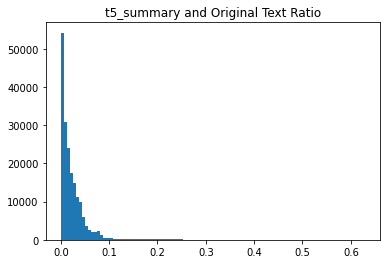

In [ ]:
df_filter = df[df['Text'] != df['t5_summary']]
plt.hist(df_filter['t5_summary'].apply(lambda x: len(x.split())) / df_filter['Text'].apply(lambda x: len(x.split())),  bins = 100)
plt.title('t5_summary and Original Text Ratio')
plt.show()

In [ ]:
df.to_csv('filtered_export_t5_small.csv', index = False)